# `scikitlearn`

As I am starting out to read some `scikitlearn` tutorials I immedialtely spot some differences between `scikitlearn` and modelling in `R`.

- for `scikitlearn` data needs to be numerical, so all categorical data needs to be converted to dummy variables first.
- predictor and response variable have to be given in "matrix input", there is no such thing as the formula input in `R`
- the moenclature for the predictor matrix is `X` and for the response `y`


# Sample Data

We have to provide the data in x,y format and have to convert all categoricals before hand. There are some sample datasets that come with `scikitlearn` but they are already processed and contain no categorical variables. Here is an example

In [1]:
from sklearn import datasets

boston = datasets.load_boston()

print(boston.data)
print(boston.feature_names)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']



Usually our datasets will not come that neatly prepared and we wont have `numpy` arrays but `pandas` dataframs. So alternatively we will get our datasets from `seaborn`


In [2]:
import seaborn as sns

df = sns.load_dataset('titanic')

df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True




## Investigating Data Set

In [3]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In `R` we would use `summary` to look at the number of levels of each factor variable. In `python` we would have to iterate over the categorical column names and use `pd.Series.value_counts()` which is a bit cumbersome. However this approach also gives us a bit more control than we have with `summary()` in `R`. 

In [4]:
import pandas as pd
import numpy as np

def summary(df):
    
    print('categorical variables--------------------------------')
    
    for cat_var in df.select_dtypes(exclude = np.number).columns:

        counts = df[cat_var] \
            .value_counts( dropna= False ) \
            .to_frame()

        perc = df[cat_var] \
            .value_counts( dropna= False, normalize = True ) \
            .to_frame()
            
        print( df[cat_var].dtypes )
        print( counts.join(perc, lsuffix = '_n', rsuffix = '_perc' ) )
        print('')
    
    print('numerical variables----------------------------------')
    
    print( df.describe() )
          
summary(df)    


categorical variables--------------------------------
object
        sex_n  sex_perc
male      577  0.647587
female    314  0.352413

object
     embarked_n  embarked_perc
S           644       0.722783
C           168       0.188552
Q            77       0.086420
NaN           2       0.002245

category
        class_n  class_perc
Third       491    0.551066
First       216    0.242424
Second      184    0.206510

object
       who_n  who_perc
man      537  0.602694
woman    271  0.304153
child     83  0.093154

bool
       adult_male_n  adult_male_perc
True            537         0.602694
False           354         0.397306

category
     deck_n  deck_perc
NaN     688   0.772166
C        59   0.066218
B        47   0.052750
D        33   0.037037
E        32   0.035915
A        15   0.016835
F        13   0.014590
G         4   0.004489

object
             embark_town_n  embark_town_perc
Southampton            644          0.722783
Cherbourg              168          0.188552
Queen

Some variables do have missing values which we have to impute.

# Encode categorical variables for Imputing missing values

`scikit-learn` has some standard imputation methods like mean and median. There is a package called `fancyimpute` which can do knn imputing but has a huge list of required packages a lot of which require `C++` compilation. We will therefore just use `scikti-learn` to start with. Like everything in scikitlearn we can only use it for numerical data. In the development version of scikitlearn we can find `sklearn.preprocessing.CategoricalEncoder` which apparently allows you to do easy onestep encoding and decoding. Then there is the package `sklearn-pandas` which also has a CategoricalEncoder and bridges both packages and is recommended on the `pandas` documentation homepage.

For exercise purposes we will start building our own Categorical Encoder. We will use `pd.factorize()` to convert the categorical columns to numerical, it returns a numerical array and an index which allows us to convert the array back to the categories. However there are some issues for this function.

- `NaN` will be represented with -1 in the array but dropped from the index in none `dtype == 'category'` columns. Which makes recoding awkward
- There is a bug for columns of `dtype == 'category'` which only returns a numerical index and makes it impossible to recode back to categories from it. This bug will be fixed in `pandas 0.23` (as I am writing this the release version is `pandas 0.19`). This means we have to implement an ugly fix into our Encoder Class :-(. [bugreport](https://github.com/pandas-dev/pandas/pull/19938).
- `NaN` for columns of `dtype == 'category'` will not be encoded with a random integer within the range of the number of unique values. We need a consistent NaN integer for imputation.

**categories in pandas seem to be a new feature which is incompatible whith other packages such as numpy and scikitlearn, we will standardize all none-numerical data to strings**

## Convert all none-numericals to dtype category

In [5]:
for col in df.select_dtypes(exclude = np.number).columns:
    df[col] = df[col].astype('object')


## Categorical Encoder

In [6]:

class CategoricalEncoder:
    
    columns = list()
    dtypes = list()
    indeces = dict()
    
    
    def encode(self, df):
        
        # dont want the input object to change
        df = df.copy()
        
        self.columns = df.columns
        self.dtypes = df.dtypes
        
        assert len( df.select_dtypes(exclude = [np.number, 'object']).columns ) == 0 \
        , 'convert all none-numerical columns to object first'
                
        for col in df.select_dtypes(exclude = np.number):
            df[col], self.indeces[col] = pd.factorize(df[col])
            #df[col] = df[col].astype('int') ## array is returned as float :-(
            
        return df
            
    def recode(self, df):
        
        df = df.copy()
        
        assert any( df.columns == self.columns), 'columns do not match original dataframe'
        
        for col, ind in self.indeces.items():
            df[col] = [ np.nan if x == -1 else x for x in df[col] ] ## numpy converts array to float
            df[col] = [ ind[ int(x) ] if not np.isnan(x) else x for x in df[col] ] ## we need to convert back to int 
            
        df = df.loc[:,self.columns]
            
        for col, dtype in zip(df.columns, self.dtypes):
            df[col] = df[col].astype(dtype.name)
                     
        return df
    


### Test Categorical Encoder

In [7]:

Encoder = CategoricalEncoder()

df_enc = Encoder.encode(df)

df_rec = Encoder.recode(df_enc)

assert df.equals(df_rec), 'Encoder does not recode correctly'


## Impute

We will impute categroical with most frequent category and numericals with mean

In [8]:
from sklearn.preprocessing import Imputer

Encoder = CategoricalEncoder()

df_enc = Encoder.encode(df)

df_imp = df_enc.copy()

# numericals
col_num = df.select_dtypes(include = np.number).columns
Imputer_mean = Imputer(strategy = 'mean')
df_imp.loc[:, col_num] = Imputer_mean.fit_transform( df_imp.loc[:, col_num] )

# categoricals
col_cat = df.select_dtypes(exclude = np.number).columns
Imputer_freq = Imputer(strategy = 'most_frequent', missing_values = -1)
df_imp.loc[:, col_cat]  = Imputer_freq.fit_transform( df_imp.loc[:, col_cat] )

df_imp_rec = Encoder.recode(df_imp)
 
assert not df_imp_rec.isna().as_matrix().any()
assert df_imp_rec.shape == df.shape


## Transforming numerical variables

### Boxcox

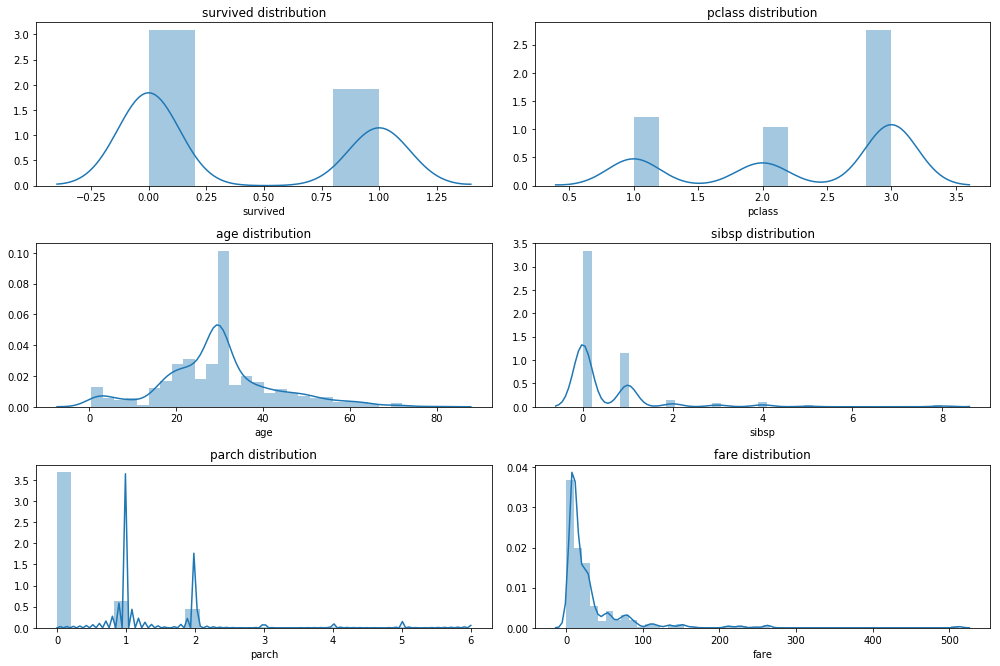

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline


def plot_hist_grid(df, x, y ):
    
    fig = plt.figure(figsize=(14, 12))

    for i, col in enumerate( df.select_dtypes( include = np.number).columns ):
        ax = fig.add_subplot(x,y,i+1)
        sns.distplot( df[col].dropna() )
        ax.set_title(col + ' distribution')

    fig.tight_layout() ## we need this so the histogram titles do not overlap

    
plot_hist_grid(df_imp_rec, 4, 2)

none of the numerical variables have a normal distribution, the best option here would be to use a `Boxcox` or a `Yeo Johnson` transformation if we plan on using a parametric model. Both algorithms return a lambda value that allows us to apply the same transformation to new data. Unfortunately the `python` implementations are a bit limited at the moment. There is `sklearn.preprocessing.PowerTransformer` in the newest development version of `scikit-learn` whis supports `Boxcox` transformations. Then there is `scipy.stats.boxcox` which is a bit cumbersome and requires a lot of manual work. Also `Boxcox` is a bit subborn and requires positive values. Probably feature `processing` is something you want to keep doing in `R` using `recipes` or `caret`.

age         0.822999
fare        0.180913
parch      -0.767354
pclass      1.774717
sibsp      -0.484927
survived   -0.312346
dtype: float64


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,-6.336364,2.172058,18.275863,-11.647712,-32.911718,3.910416
std,5.011771,1.456663,7.261755,8.111499,18.608375,1.965039
min,-10.289796,0.010039,-0.608408,-17.176613,-43.335522,-3.124792
25%,-10.289796,1.381702,14.257979,-17.176613,-43.335522,2.510059
50%,-10.289796,3.419353,18.590518,-17.176613,-43.335522,3.435259
75%,0.009935,3.419353,21.455870,0.009926,-43.335522,4.761225
max,0.009935,3.419353,43.544598,1.310322,0.974077,11.561796


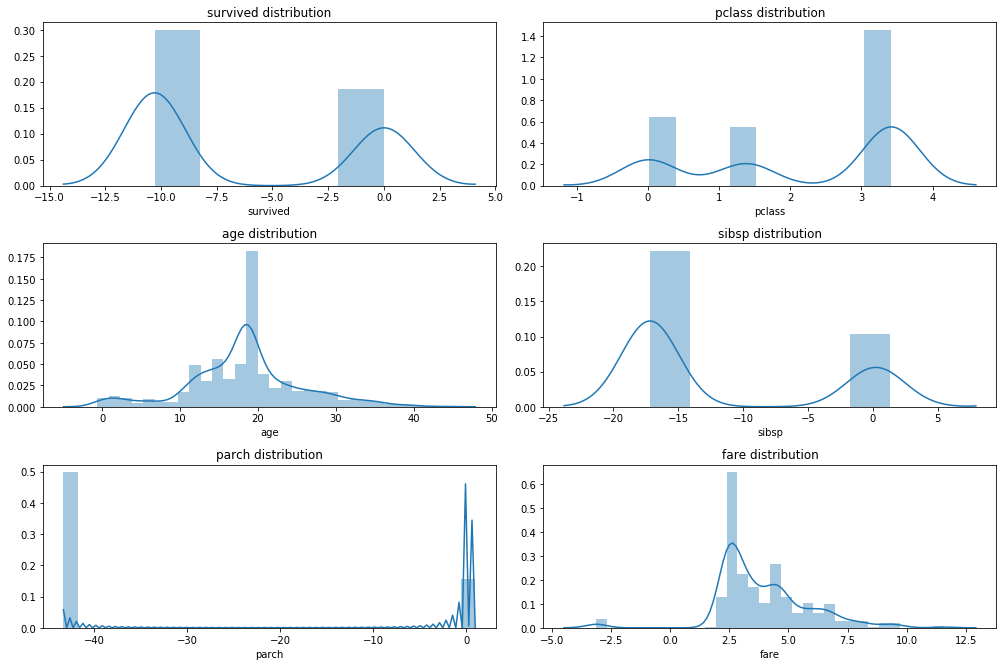

In [10]:
from scipy.stats import boxcox

df_trans = df_imp_rec.copy()

# boxcox needs values > 0
for col in df_imp_rec.select_dtypes(include = np.number).columns:
    df_trans[col] = df_trans[col] + 0.01

# scipy.stats implementaion cannot handle NA values
# df_trans = df_trans.dropna()

lambdas = dict()

for col in df_imp_rec.select_dtypes(include = np.number).columns:
    df_trans[col], lambdas[col] = boxcox(df_trans[col])
    
print( pd.Series(lambdas) )

plot_hist_grid(df_trans, 4, 2)

df_trans.describe()


### Scale

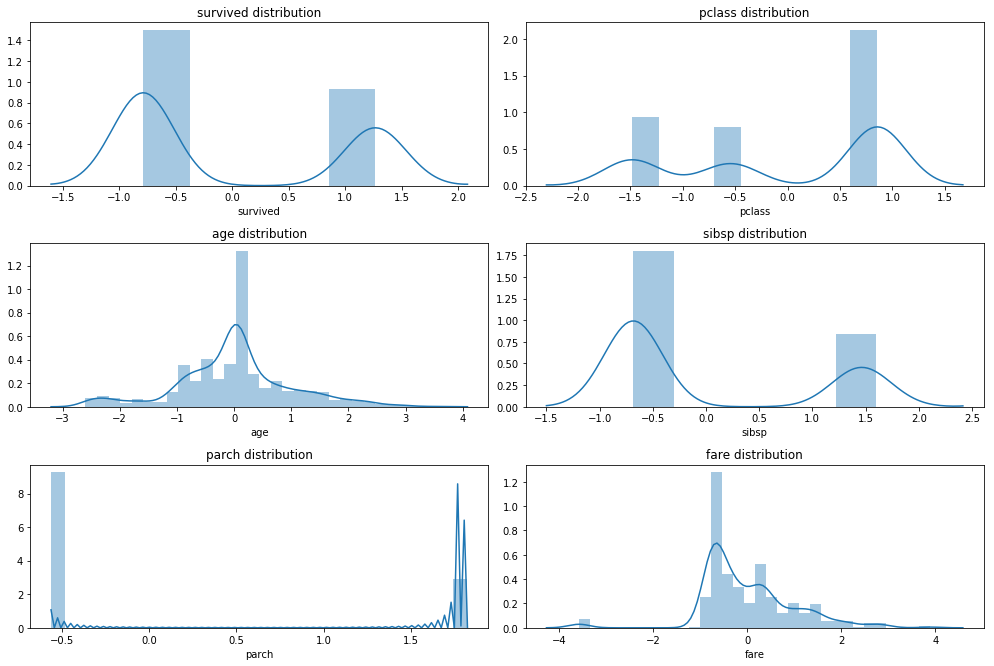

In [11]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()

cols_num = df_trans.select_dtypes(include = np.number).columns
df_trans.loc[:,cols_num] = Scaler.fit_transform( df_trans.loc[:,cols_num] )

plot_hist_grid(df_trans, 4, 2)


## Final Selection

Finally we have some duplicate information in our dataframe which we will drop.

In [12]:
df_fin = df_trans.drop(['survived','pclass'], axis = 1)

# Reencoding Categorical variables for modelling

In `R` we did not have to worry much about reencoding categorical data it would usually be taken care of by most modelling algorithms. In `python` we have to do this manually.

There is an excellent [guide](http://pbpython.com/categorical-encoding.html) from which I will try to replicate some of the examples. Digging into the topic a bit I also learned that there are more encoding techniques for categorical variabels than just the regular *dummy encoding* which is used by `R` as the gold standard. There is also *one hot encoding* which creates for a categorical variable with *k* categories *k* binary columns (compared to *k-1* columns with dummy encoding). Beyond those two methods there are plenty more as described in this [article](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/). For these types of encodings the categorical values will be replaced with the summarized values of the response variable of all observations from the same category such as the sum or the mean.  This is similar to the weight of evidence encoding which is commonly used when developing credit risk score cards with logistic regression, as I have previously at [in this post](http://rpubs.com/erblast/creditrisk).

Returning to the samply data we can see that we have duplicated information such as the columns sex, who, and  adult_male. For the sake of this article we will select only one of each of those and chose prefer categorical string encoding over variables that already have numerical or binary encoding.

## Create dummy variables 

In [13]:
df_dum = pd.get_dummies(df_fin
               , drop_first = True ## k-1 dummy variables
              )

df_dum.head()


,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Queenstown,embark_town_Southampton,alive_yes,alone_True
0,-0.553605,1.437981,-0.560482,-0.776991,1,0,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0
1,0.656833,1.437981,-0.560482,1.284747,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-0.239527,-0.681996,-0.560482,-0.711671,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,1,1
3,0.438158,1.437981,-0.560482,0.968817,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,0.438158,-0.681996,-0.560482,-0.700078,1,0,1,0,1,1,...,0,1,0,0,0,0,0,1,0,1


# Fitting a decision tree
We will fit an examplatory decision tree to the data. Not because it is the best model to use here but because Decision Trees can easily be visualised graphically and it is a good exercise to try that out. We will perform a 10 x 10-fold cross validation and a randomized parameter search.

## Hyperparameter Tuning
Traditionally one would use a grid search of all possible hyperparameter combinations in order to optimize model performance. Recently a number of more efficient algorithms have been developed.

- *The submodel trick:* For some ensemble methods one of the tuning parameters usually reflects the number of contrbuting models such as the number of trees in a random forest. In order to train a forest with 1000 trees we have in the process also to train models for all numbers of trees between 1:1000. The submodel trick simpoly implies that we are saving these intermediary models for evaluation. The submodel trick is used by many model implementations in the `caret` package. Usually the implementation of the submodel trick outweighs the benefits of the other hyperparameter optimizations strategies.
- *Adaptive Resampling:* In order to validate model performance we have to use k-fold cross validation, k usually depends on the size and variance in the data. Sometimes variance in the data is so high that each k-fold split of the data gives us different results, so we have to perform x times k-fold cross validaztion. For most of the hyperparameter combinations in a grid search however we can probably already predict after analysing just a few cross validation pairs that they will not produce better results than the best combination that we have found so far. Max Kuhn has presented to techniques for prediciting model performance after only a few resampling rounds in his [2014 paper](https://arxiv.org/pdf/1405.6974.pdf) which have been experimentally implemented in `caret`.
- *Randomized Search:* Experience in hyperparamter tuning has shown that only a few of the tunable parameters of a model actually have an influence on model performance. Which those parameters are however is largely influenced by the dataset. In a case where the model performance is largely dominated by a single parameter a randomized search covers a larger range of that parameter than a grid search as demonstrated in this [paper] and exemplified in the illustration below. (http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf). Randomized search is implemented in `caret` as well as in `scikitlearn`

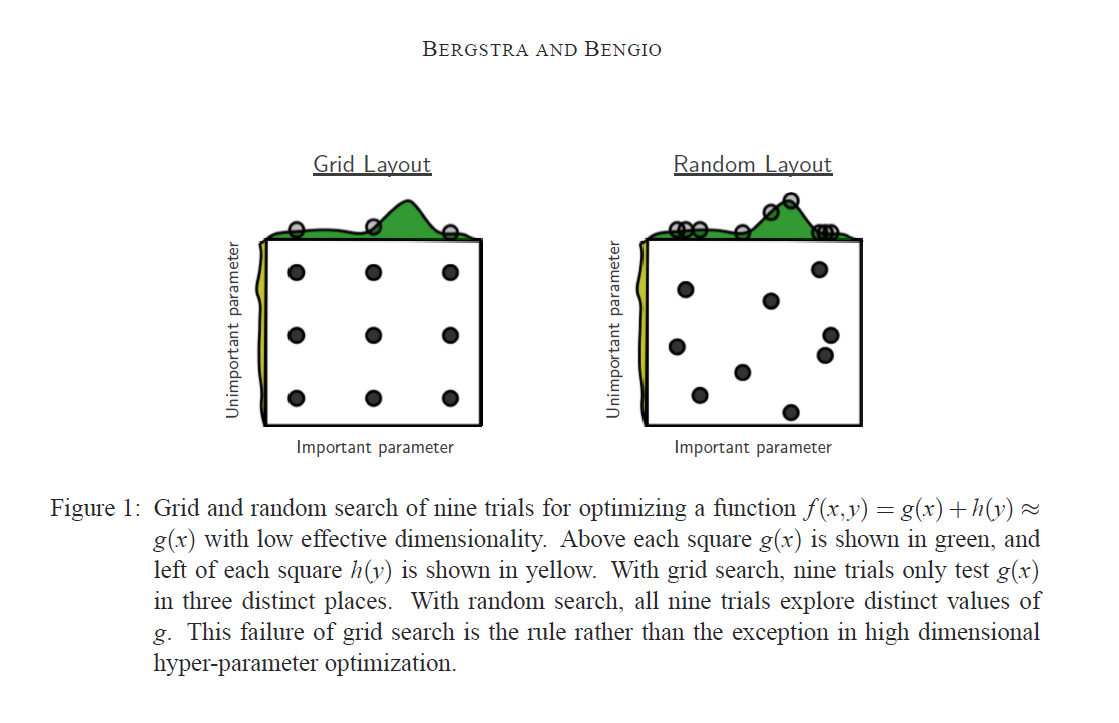

## Randomized parameter search
Instead of specifiying a range for certain parameters we will provide a distribution to sample from an the number of iterations the algorithm should use. We can get the distributions from the `scipy.stats` package. Since we have no prior knowledge about which distributions to chose we simply chose `stats.randint` for discrete values and `stats.uniform` for contineous values.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy import stats


clf = DecisionTreeClassifier()

param_dist = {'min_samples_split': stats.randint(2,250)
             , 'min_samples_leaf': stats.randint(1,500)
             , 'min_impurity_decrease' : stats.uniform(0,1)
             , 'max_features': stats.uniform(0,1) }

n_iter = 2500

random_search = RandomizedSearchCV(clf
                                   , param_dist
                                   , n_iter = n_iter
                                   , scoring = 'roc_auc'
                                   , cv = RepeatedKFold( n_splits = 10, n_repeats = 10 )
                                   , verbose = True
                                   , n_jobs = 4 ## parallel processing
                                   , return_train_score = True
                                  )

x = df_dum.drop('alive_yes', axis = 1)
y = df_dum['alive_yes']

random_search.fit(x,y)


Fitting 100 folds for each of 2500 candidates, totalling 250000 fits


[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 3742 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 9742 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 18142 tasks      | elapsed:   40.4s
[Parallel(n_jobs=4)]: Done 28942 tasks      | elapsed:   59.6s
[Parallel(n_jobs=4)]: Done 42142 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 57742 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 75742 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 96142 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 118942 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 144142 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 171742 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 201742 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 234142 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 250000 out of 250000 | elapsed:  7.7min finished


RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x0000023D28FA4828>,
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=2500, n_jobs=4,
          param_distributions={'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023D289AF2B0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023D28F9B780>, 'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023D28FA44A8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023D28FA4A58>},
          pre_dispatc

In [278]:
res = pd.DataFrame( random_search.cv_results_ )

res.sort_values('rank_test_score') 


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,...,split98_test_score,split98_train_score,split99_test_score,split99_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1003,0.005627,0.003318,0.846431,0.849628,0.566372,0.00596982,34,21,"{'max_features': 0.5663720435130193, 'min_impu...",1,...,0.831761,0.856292,0.855897,0.855110,0.795722,0.849315,0.005767,0.005607,0.047302,0.018151
608,0.003125,0.002031,0.845424,0.848544,0.657057,0.00922638,50,136,"{'max_features': 0.6570568295965241, 'min_impu...",2,...,0.781709,0.826003,0.875385,0.867712,0.803743,0.858612,0.006629,0.005254,0.046505,0.020334
1972,0.003125,0.001406,0.842624,0.842754,0.496531,0.00279635,22,229,"{'max_features': 0.4965314453765429, 'min_impu...",3,...,0.792977,0.856156,0.848205,0.847137,0.803743,0.860396,0.006250,0.004471,0.048294,0.014184
2306,0.003468,0.001839,0.818442,0.818227,0.968745,0.0373162,13,129,"{'max_features': 0.9687448329147147, 'min_impu...",4,...,0.799790,0.822511,0.795385,0.823442,0.770053,0.825694,0.002569,0.001741,0.041372,0.010649
38,0.004239,0.001953,0.818076,0.818612,0.843011,0.0249646,35,85,"{'max_features': 0.8430114616498686, 'min_impu...",5,...,0.799790,0.822511,0.795385,0.823442,0.770053,0.825694,0.007132,0.004434,0.040667,0.010372
641,0.003369,0.001974,0.816286,0.817370,0.832203,0.016994,34,197,"{'max_features': 0.8322029571430009, 'min_impu...",6,...,0.799790,0.822511,0.795385,0.823442,0.770053,0.825694,0.003596,0.003528,0.044126,0.011309
2382,0.003593,0.001406,0.815630,0.826656,0.237852,0.00296843,12,101,"{'max_features': 0.2378517504065728, 'min_impu...",7,...,0.800052,0.803180,0.827179,0.826045,0.810160,0.863521,0.008798,0.004471,0.050930,0.025842
1718,0.003059,0.001654,0.812940,0.817989,0.643853,0.016559,11,49,"{'max_features': 0.6438527161459392, 'min_impu...",8,...,0.738470,0.784847,0.819231,0.839203,0.775936,0.830203,0.005997,0.005168,0.046933,0.023112
1423,0.003750,0.001562,0.811583,0.811120,0.826849,0.0379004,38,45,"{'max_features': 0.8268489907562133, 'min_impu...",9,...,0.799790,0.822511,0.756154,0.783405,0.770053,0.825694,0.007368,0.004687,0.047467,0.017404
1979,0.002187,0.001875,0.809852,0.816584,0.261417,0.00372727,39,185,"{'max_features': 0.2614165951055234, 'min_impu...",10,...,0.783805,0.799217,0.820256,0.846763,0.636364,0.777358,0.005421,0.005077,0.057206,0.029454


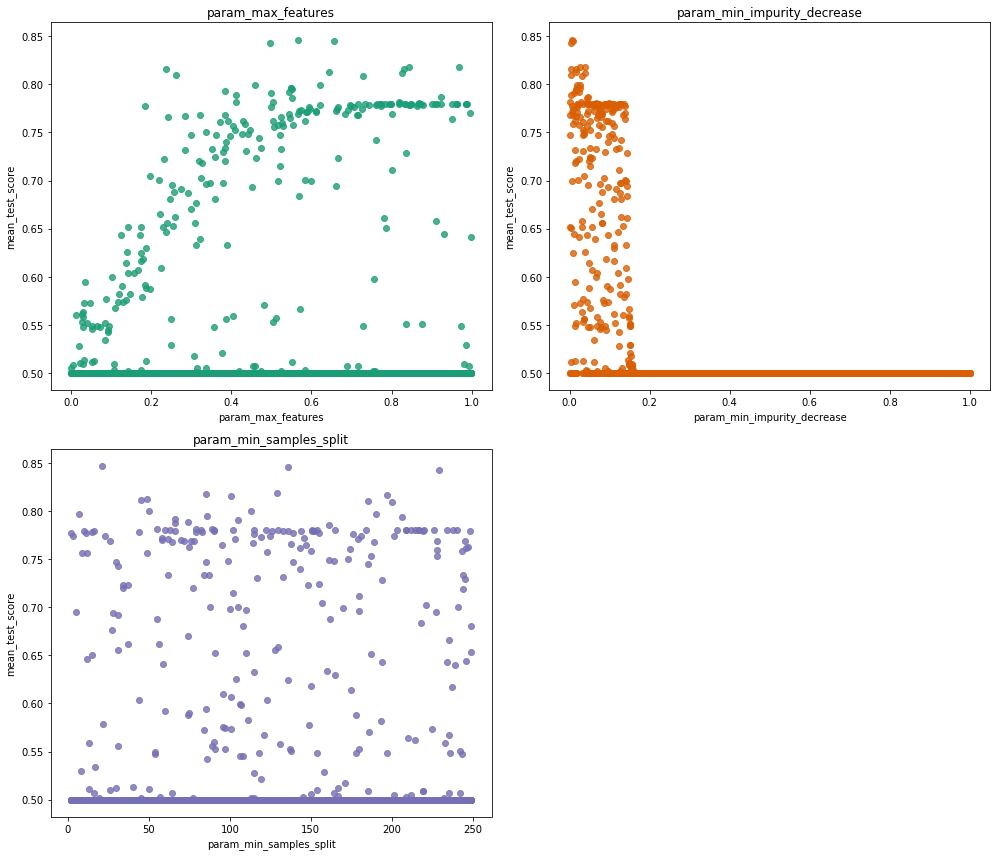

In [279]:

from matplotlib import cm

params = ['param_max_features'
         , 'param_min_impurity_decrease'
         , 'param_min_samples_split']


cmap = cm.get_cmap('Dark2')

fig = plt.figure( figsize=(14, 12) )

for i, param in enumerate(params):

    ax = fig.add_subplot(2,2,i+1)
    
    sns.regplot( x = param
               , y = 'mean_test_score'
               , data = res # res.query('mean_test_score > 0.5') 
               , scatter_kws = { 'color' :cmap(i) }
               , fit_reg = False
             )
    
    
    
    ax.set_title(param)

  
fig.tight_layout() ## we need this so the histogram titles do not overlap



We can see that we only have a very narrow range for which min_impurity_decrease is optimal, the param_max_features value probably should be kept at maximum and min_samples_split probably does not have a large influence on performance.

# Visualize Tree

Scikitlearn allows us to export a decision tree graphic in GraphViz dot language format. We can interpret this format using `PyDotPlus`. In order for this to work we need to [download](https://graphviz.gitlab.io/_pages/Download/Download_windows.html) and install `GraphViz` and put the installation folder into the PATH variable as well as pip installing the `graphviz` python package. See the [documentation](http://graphviz.readthedocs.io/en/stable/manual.html) for installation instructions. For this tree we loose some of the interpretability because of the scaling and the boxcox transformation.



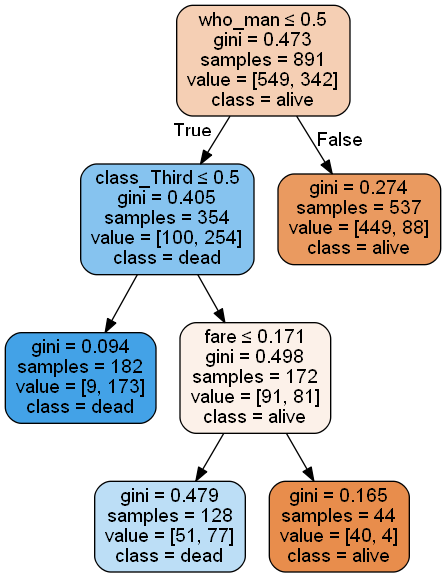

In [280]:

tree = random_search.best_estimator_

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(tree
                , out_file = dot_data
                , filled = True
                , rounded = True
                , special_characters = True
                , feature_names = x.columns
                , class_names = ['alive', 'dead'] )

graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )  

Image( graph.create_png() ) 


# Feature Importance

In [281]:
pd.DataFrame({ 'features' : x.columns, 'importance': tree.feature_importances_}) \
    .sort_values('importance', ascending = False)

,features,importance
9,who_man,0.693665
8,class_Third,0.215766
3,fare,0.090569
0,age,0.000000
12,deck_B,0.000000
19,embark_town_Southampton,0.000000
18,embark_town_Queenstown,0.000000
17,deck_G,0.000000
16,deck_F,0.000000
15,deck_E,0.000000


# ROC Curve
Lets visualize a ROC curve for the tree with the best parameters and all 10x10x cross validation sets. Loosely inspired by this example [code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

##  Get tpr, fpr values for cv pairs

In [282]:

from sklearn.model_selection import cross_val_score
import sklearn

cv = sklearn.model_selection.RepeatedKFold(10,10)

tree = random_search.best_estimator_

results_df = pd.DataFrame( columns = ['fold', 'fpr', 'tpr', 'thresh', 'auc'] )


for i, split in enumerate(cv.split(x,y)):
    
    train, test = split
    
    tree = tree.fit(x.loc[train,:], y[train])
    
    pred_arr =  tree.predict_proba( x.loc[test,:] )
    # predict outputs probability for positive and negative outcome
    pred =  pd.DataFrame(pred_arr).loc[:,1]
    
    real = y[test]
    
    fpr, tpr, thresh = sklearn.metrics.roc_curve( y_true = real, y_score = pred)
    
    auc = sklearn.metrics.auc(fpr, tpr)
    
    rocs = pd.DataFrame({'fold': i, 'fpr': fpr, 'tpr': tpr , 'thresh': thresh, 'auc': auc})
    
    results_df = pd.concat([results_df, rocs], axis = 0)
    
    results_df_reind = results_df.reset_index( inplace = False ) \
        .rename(columns = {'index':'seq'})

results_df_reind.head(20)


,seq,auc,fold,fpr,thresh,tpr
0,0,0.824580,0,0.000000,1.957576,0.000000
1,1,0.824580,0,0.035714,0.957576,0.441176
2,2,0.824580,0,0.178571,0.567568,0.735294
3,3,0.824580,0,0.339286,0.349206,0.823529
4,4,0.824580,0,0.392857,0.179487,0.852941
5,5,0.824580,0,1.000000,0.100000,1.000000
6,0,0.811735,1,0.000000,1.952941,0.000000
7,1,0.811735,1,0.020408,0.952941,0.150000
8,2,0.811735,1,0.020408,0.911392,0.500000
9,3,0.811735,1,0.183673,0.616071,0.675000


In [283]:
results_gr = results_df_reind.groupby('seq') \
    .agg({'tpr':['mean', 'sem']
          , 'fpr':['mean', 'sem']
          , 'thresh':'mean' 
          } )  
    
results_gr


tpr                 fpr              thresh
         mean       sem      mean       sem      mean
seq                                                  
0    0.137538  0.019880  0.000000  0.000000  1.576246
1    0.494159  0.015181  0.041838  0.004340  0.865548
2    0.693223  0.013437  0.141371  0.014459  0.594917
3    0.816120  0.012175  0.345799  0.029349  0.370414
4    0.903553  0.011215  0.622122  0.036881  0.200336
5    0.954497  0.010254  0.812209  0.038490  0.148759
6    0.985819  0.010079  0.931967  0.045116  0.127923
7    1.000000  0.000000  1.000000  0.000000  0.111083

## Plot ROC Curve

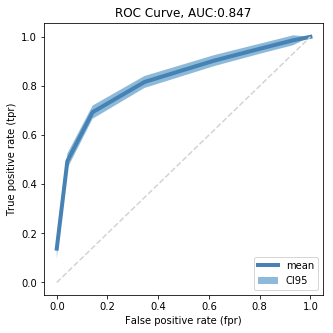

In [284]:

cmap = cm.get_cmap('Dark2')

fig = plt.figure( figsize=(5, 5) )


plt.plot( results_gr.fpr['mean'], results_gr.tpr['mean']
         , color = 'steelblue'
         , lw = 4 
         , label = 'mean')

plt.plot( [0,1],[0,1]
         , color = 'lightgrey'
         , linestyle='--' ) 

plt.fill_between( results_gr.fpr['mean']
                 , results_gr.tpr['mean'] - 2 * results_gr.tpr['sem']
                 , results_gr.tpr['mean'] + 2 * results_gr.tpr['sem']
                 , alpha = 0.5 
                 , label = 'CI95' )

plt.xlabel('False positive rate (fpr)')
plt.ylabel('True positive rate (tpr)')
plt.legend( loc = 'lower right')
plt.title('ROC Curve, AUC:{}'.format( results_df_reind.auc.unique().mean().round(3) ))

plt.show()